In [111]:
#Cell_1.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter('ignore')

import plotly

plt.rcParams['font.family'] = 'Yu Mincho' # for Japanese in graph (Win)

In [112]:
#Cell_2.
from greykite.algo.changepoint.adalasso.changepoint_detector import ChangepointDetector
from greykite.algo.forecast.silverkite.constants.silverkite_column import SilverkiteColumn
from greykite.common.features.timeseries_features import get_available_holidays_across_countries
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results

In [113]:
#Cell_3.
csv_in="6501_2018.csv"
df=pd.read_csv(csv_in,skiprows=1,header=0,delimiter=',',encoding="shift-jis")
print(df.shape) #確認
print(df.head()) #確認
print(type(df['日付'][0]))
df['日付']=pd.to_datetime(df['日付'])
print(type(df['日付'][0]))

(120, 7)
           日付     始値     高値     安値     終値       出来高  終値調整値
0  2018-01-04  893.0  893.7  884.3  890.5  21669000  890.5
1  2018-01-05  892.9  903.5  892.2  896.6  25565000  896.6
2  2018-01-09  910.0  914.9  907.1  912.5  24605000  912.5
3  2018-01-10  912.0  917.8  906.2  917.5  20409000  917.5
4  2018-01-11  911.1  914.3  904.6  914.3  13674000  914.3
<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [114]:
#Cell_4.
df_d=df.copy()
df_d['経過日数']=df_d['日付']
df_d['経過日数']-=df_d['経過日数'][0]
print(type(df_d['経過日数'][0]))
df_d['経過日数']/=np.timedelta64(1,'D')
print(type(df_d['経過日数'][0]))
print(df_d.head())

<class 'pandas._libs.tslibs.timedeltas.Timedelta'>
<class 'numpy.float64'>
          日付     始値     高値     安値     終値       出来高  終値調整値  経過日数
0 2018-01-04  893.0  893.7  884.3  890.5  21669000  890.5   0.0
1 2018-01-05  892.9  903.5  892.2  896.6  25565000  896.6   1.0
2 2018-01-09  910.0  914.9  907.1  912.5  24605000  912.5   5.0
3 2018-01-10  912.0  917.8  906.2  917.5  20409000  917.5   6.0
4 2018-01-11  911.1  914.3  904.6  914.3  13674000  914.3   7.0


In [115]:
#Cell_5.
df_d['week']=0
print(df_d.shape)
display(df_d.head())

(120, 9)


,日付,始値,高値,安値,終値,出来高,終値調整値,経過日数,week
0,2018-01-04,893.0,893.7,884.3,890.5,21669000,890.5,0.0,0
1,2018-01-05,892.9,903.5,892.2,896.6,25565000,896.6,1.0,0
2,2018-01-09,910.0,914.9,907.1,912.5,24605000,912.5,5.0,0
3,2018-01-10,912.0,917.8,906.2,917.5,20409000,917.5,6.0,0
4,2018-01-11,911.1,914.3,904.6,914.3,13674000,914.3,7.0,0


In [116]:
#Cell_6.
df_d['week'] = df_d['経過日数']//7 + 1

In [117]:
#Cell_7.
display(df_d.head())
display(df_d.tail())

,日付,始値,高値,安値,終値,出来高,終値調整値,経過日数,week
0,2018-01-04,893.0,893.7,884.3,890.5,21669000,890.5,0.0,1.0
1,2018-01-05,892.9,903.5,892.2,896.6,25565000,896.6,1.0,1.0
2,2018-01-09,910.0,914.9,907.1,912.5,24605000,912.5,5.0,1.0
3,2018-01-10,912.0,917.8,906.2,917.5,20409000,917.5,6.0,1.0
4,2018-01-11,911.1,914.3,904.6,914.3,13674000,914.3,7.0,2.0


,日付,始値,高値,安値,終値,出来高,終値調整値,経過日数,week
115,2018-06-22,772.2,784.9,771.0,783.0,11868000,783.0,169.0,25.0
116,2018-06-25,786.0,792.2,780.2,781.6,9352000,781.6,172.0,25.0
117,2018-06-26,777.8,785.3,774.0,779.1,14870000,779.1,173.0,25.0
118,2018-06-27,780.5,782.9,766.7,768.3,13656000,768.3,174.0,25.0
119,2018-06-28,765.9,773.1,764.0,772.2,12331000,772.2,175.0,26.0


In [118]:
#Cell_8.
#Extract 2018 and onward.
interest = pd.read_csv('d1-5-5.csv',skiprows=525,encoding='cp932')
display(interest.head())

,Unnamed: 0,1.5,0,-0.06,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28
0,18.0,1.5,0,-0.04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.5,0,-0.03,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.5,0,-0.04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.5,0,-0.04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.5,0,-0.04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
#Cell_9.
interest=interest.iloc[:,0:2]
interest.columns=['week','US']
display(interest.head())
print(interest.info())
for i in range(110):
    interest.loc[i,'week']=i+1
display(interest.head(110))



,week,US
0,18.0,1.5
1,NaN,1.5
2,NaN,1.5
3,NaN,1.5
4,NaN,1.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   week    2 non-null      float64
 1   US      77 non-null     float64
dtypes: float64(2)
memory usage: 1.3 KB
None


,week,US
0,1.0,1.5
1,2.0,1.5
2,3.0,1.5
3,4.0,1.5
4,5.0,1.5
...,...,...
105,106.0,NaN
106,107.0,NaN
107,108.0,NaN
108,109.0,NaN


In [122]:
#Cell_10.
interest2 = interest.iloc[0:110,:]
display(interest2)

,week,US
0,1.0,1.5
1,2.0,1.5
2,3.0,1.5
3,4.0,1.5
4,5.0,1.5
...,...,...
105,106.0,NaN
106,107.0,NaN
107,108.0,NaN
108,109.0,NaN


In [123]:
#Cell_11.
df2= pd.merge(df_d,interest2,on='week',how='left')
df2=df2.drop('経過日数',axis=1)
display(df2.head())
display(df2.tail())

,日付,始値,高値,安値,終値,出来高,終値調整値,week,US
0,2018-01-04,893.0,893.7,884.3,890.5,21669000,890.5,1.0,1.5
1,2018-01-05,892.9,903.5,892.2,896.6,25565000,896.6,1.0,1.5
2,2018-01-09,910.0,914.9,907.1,912.5,24605000,912.5,1.0,1.5
3,2018-01-10,912.0,917.8,906.2,917.5,20409000,917.5,1.0,1.5
4,2018-01-11,911.1,914.3,904.6,914.3,13674000,914.3,2.0,1.5


,日付,始値,高値,安値,終値,出来高,終値調整値,week,US
115,2018-06-22,772.2,784.9,771.0,783.0,11868000,783.0,25.0,2.0
116,2018-06-25,786.0,792.2,780.2,781.6,9352000,781.6,25.0,2.0
117,2018-06-26,777.8,785.3,774.0,779.1,14870000,779.1,25.0,2.0
118,2018-06-27,780.5,782.9,766.7,768.3,13656000,768.3,25.0,2.0
119,2018-06-28,765.9,773.1,764.0,772.2,12331000,772.2,26.0,2.0


In [124]:
#Cell_12.
metadata = MetadataParam(
    time_col="日付", # 日付の列名
    value_col="終値", # 値の列名
    freq="D", # 日付の単位
    train_end_date=pd.datetime(2018, 6, 25)
)

In [125]:
#Cell_13.
regressors=dict(
    regressor_cols=[
        ["出来高", "US"]
    ]
)

In [126]:
#Cell_14.
yearly_seasonality_order = 10
weekly_seasonality_order = 5
seasonality = {
    "yearly_seasonality": yearly_seasonality_order,
    "quarterly_seasonality": False,
    "monthly_seasonality": False,
    "weekly_seasonality": weekly_seasonality_order,
    "daily_seasonality": False
}

In [127]:
#Cell_15.
growth = {
 "growth_term": "linear"
}
changepoints = {
 "changepoints_dict": dict(
     method="auto",
     yearly_seasonality_order=10,
     regularization_strength=0.5,
     resample_freq="7D",
     potential_changepoint_n=25,
     yearly_seasonality_change_freq="365D",
     no_changepoint_distance_from_end="365D"
 )
}

In [128]:
#Cell_16.
model_components = ModelComponentsParam(
    seasonality=seasonality,
    growth=growth,
    #events=events,
    #changepoints=changepoints,
    autoregression=None,
    regressors=regressors,
    uncertainty={
     "uncertainty_dict": "auto",
    },
    custom={
     "fit_algorithm_dict": {
         "fit_algorithm": "ridge",
     },
     #"extra_pred_cols": extra_pred_cols
    }
)

In [129]:
#Cell_17.
forecaster = Forecaster()
result = forecaster.run_forecast_config(
    df=df2,
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        forecast_horizon=14,
        coverage=0.95, # 予測区間を95%に設定
        metadata_param=metadata,
        model_components_param=model_components
    )
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [130]:
#Cell_18.
print(result.model[-1].summary(max_colwidth=50))

================================ Model Summary =================================

Number of observations: 173,   Number of features: 108
Method: Ridge regression
Number of nonzero features: 83
Regularization parameter: 0.01269

Residuals:
         Min           1Q       Median           3Q          Max
      -20.03       -5.614       0.1501        4.298        30.63

                                         Pred_col Estimate Std. Err Pr(>)_boot sig. code             95%CI
                                        Intercept    811.4    43.69     <2e-16       ***    (729.1, 894.7)
                          events_Chinese New Year    4.341    8.082      0.586             (-10.77, 22.57)
                        events_Chinese New Year-1    6.479    7.124      0.356             (-9.608, 18.94)
                        events_Chinese New Year-2   -10.95     7.48      0.114             (-22.76, 4.784)
                        events_Chinese New Year+1  -0.4855    8.653      0.948              (-1

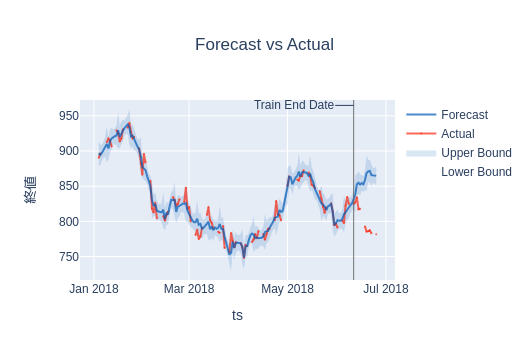

In [131]:
#Cell_19.
backtest = result.backtest
fig = backtest.plot()
plotly.io.show(fig)

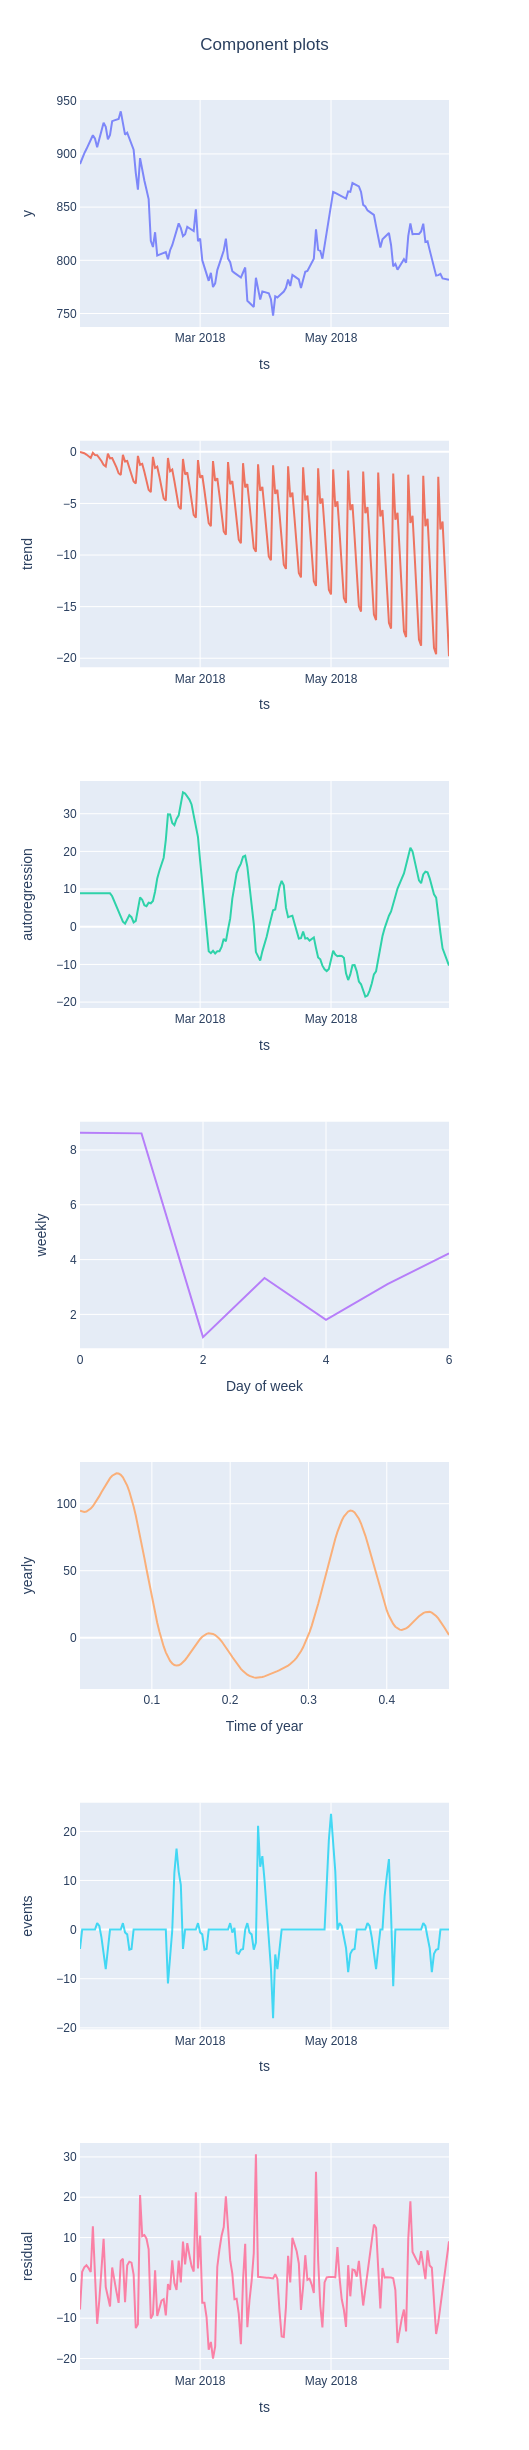

In [132]:
#Cell_20.
fig = result.forecast.plot_components()
plotly.io.show(fig)

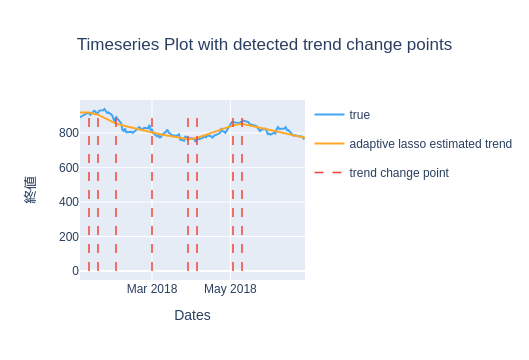

In [133]:
#Cell_21.
model = ChangepointDetector()
res = model.find_trend_changepoints(
    df=df2, # データフレーム
    time_col="日付", # 日付の列名
    value_col="終値", # 値の列名
    yearly_seasonality_order=0, # 年周期を表現するためのフーリエ級数の次数(今回は年周期を仮定してないので0)
    regularization_strength=0.5, # adaptive lassoの罰則の強さ(0~1の値)
    resample_freq="7D", # データを括る粒度
    potential_changepoint_n=20, # 変化点の数、値を大きくすると計算負荷が高くなる
    yearly_seasonality_change_freq=None, # 年周期の値が変わる間隔(今回は年周期ないので無視)
    no_changepoint_distance_from_end="14D", # ラスト14日は変化点なし
    actual_changepoint_min_distance="7D" # 変化点どうしの感覚は最低7日空ける
)

fig = model.plot(
    observation=True,
    trend_estimate=False,
    trend_change=True,
    yearly_seasonality_estimate=False,
    adaptive_lasso_estimate=True,
    plot=False)
plotly.io.show(fig)

In [137]:
#Lets try a customized model.
#Cell_22.
growth = {
    "growth_term": "linear" # 線形トレンド
}

changepoints = {
    "changepoints_dict": {
        "method": "auto",
        "yearly_seasonality_order": 0,
        "regularization_strength": 0.5,
        "resample_freq": "7D",
        "potential_changepoint_n": 20,
        "yearly_seasonality_change_freq": None,
        "no_changepoint_distance_from_end": "14D",
        "actual_changepoint_min_distance": "7D"
    }
}

seasonality = {
    "yearly_seasonality": False,
    "quarterly_seasonality": False,
    "monthly_seasonality": False,
    "weekly_seasonality": 2, # 週周期の次数
    "daily_seasonality": False
}

events = {
    "holiday_lookup_countries": None # 祝日なし
}

model_components = ModelComponentsParam(
    seasonality=seasonality,
    growth=growth,
    changepoints=changepoints,
    autoregression={
        "autoreg_dict": None # 自己回帰の項なし
    },
    events=events,
    regressors=regressors, 
    lagged_regressors={
        "lagged_regressor_dict": None # 説明変数のラグも当然なし
    },
    custom={
        "fit_algorithm_dict": {
            "fit_algorithm": "lasso"
        },
        "feature_sets_enabled": {
            SilverkiteColumn.COLS_DAY_OF_WEEK: False, # 曜日ダミーの有無
            SilverkiteColumn.COLS_TREND_WEEKEND: False, # 平日/週末とトレンドとの交互作用の有無
            SilverkiteColumn.COLS_TREND_DAY_OF_WEEK: False, # 曜日とトレンドとの交互作用の有無
            SilverkiteColumn.COLS_TREND_WEEKLY_SEAS: False # 週周期の変化を許容するかどうか
        }
    },
    uncertainty={
        "uncertainty_dict": {
            "uncertainty_method": "simple_conditional_residuals",
            "params": {
                "quantiles": [0.025, 0.975],
                "conditional_cols": ["dow_hr"], # 予測区間を月ごとに計算する
                "quantile_estimation_method": "normal_fit"
            }

        },
    }
)

In [138]:
#Cell_23.
custom_result = forecaster.run_forecast_config(
    df=df2,
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        forecast_horizon=14,
        coverage=0.95,  # 95% prediction intervals
        model_components_param=model_components,
        metadata_param=metadata
    )
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


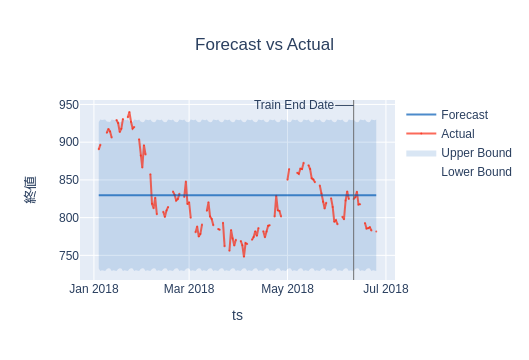

In [139]:
#Cell_24.
backtest = custom_result.backtest
fig = backtest.plot()
plotly.io.show(fig)

In [140]:
#Cell_25.
print(custom_result.model[-1].summary(max_colwidth=50))

================================ Model Summary =================================

Number of observations: 173,   Number of features: 16
Method: Lasso regression
Number of nonzero features: 12
Regularization parameter: 0.03493

Residuals:
         Min           1Q       Median           3Q          Max
      -41.52       -10.07        1.132         13.6        37.77

         Pred_col Estimate Pr(>)_split sig. code             95%CI  Prob_nonzero
        Intercept    929.9      <2e-16       ***   (777.7, 1195.0)          1.00
              出来高   -40.69       0.003        **   (-117.2, 41.66)          1.00
               US       0.       1.000             (-97.33, 113.5)          0.95
              ct1       0.       1.000           (-7695.0, 4655.0)          0.89
  sin1_tow_weekly    3.143       1.000             (-23.27, 29.05)          0.98
  cos1_tow_weekly    2.778       1.000             (-18.83, 25.37)          0.99
  sin2_tow_weekly   0.7129       1.000              (-22.78, 21.

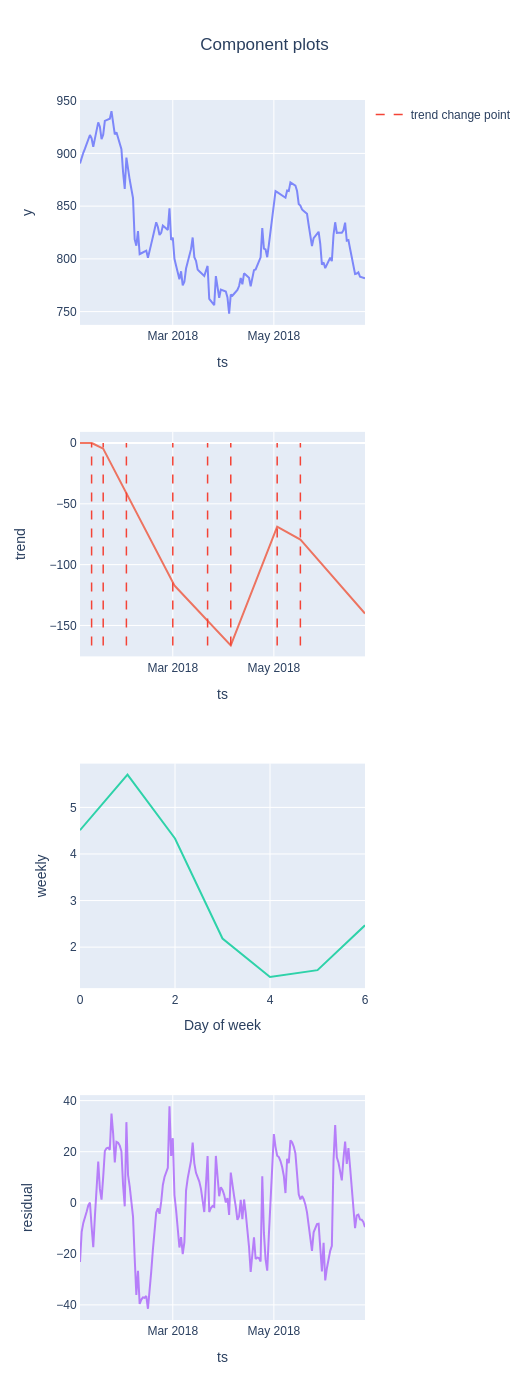

In [141]:
#Cell_26.
fig = custom_result.forecast.plot_components()
plotly.io.show(fig)

In [142]:
#Cell_27.
custom_result.backtest.test_evaluation

{'CORR': None,
 'R2': -2.1439626609004185,
 'MSE': 1182.9753720580716,
 'RMSE': 34.39440902324201,
 'MAE': 29.340062893081825,
 'MedAE': 39.66257861635228,
 'MAPE': 3.7168499615229735,
 'MedAPE': 5.021628489917555,
 'sMAPE': 1.8120382452719204,
 'Q80': 6.149257861635225,
 'Q95': 1.8888710691823847,
 'Q99': 0.7527679245282919,
 'OutsideTolerance1p': 0.8,
 'OutsideTolerance2p': 0.6,
 'OutsideTolerance3p': 0.6,
 'OutsideTolerance4p': 0.6,
 'OutsideTolerance5p': 0.5,
 'Outside Tolerance (fraction)': None,
 'R2_null_model_score': None,
 'Prediction Band Width (%)': 24.584727330952244,
 'Prediction Band Coverage (fraction)': 1.0,
 'Coverage: Lower Band': 0.9,
 'Coverage: Upper Band': 0.1,
 'Coverage Diff: Actual_Coverage - Intended_Coverage': 0.050000000000000044}